In [54]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pathlib import Path
import rasterio
from sklearn.model_selection import train_test_split

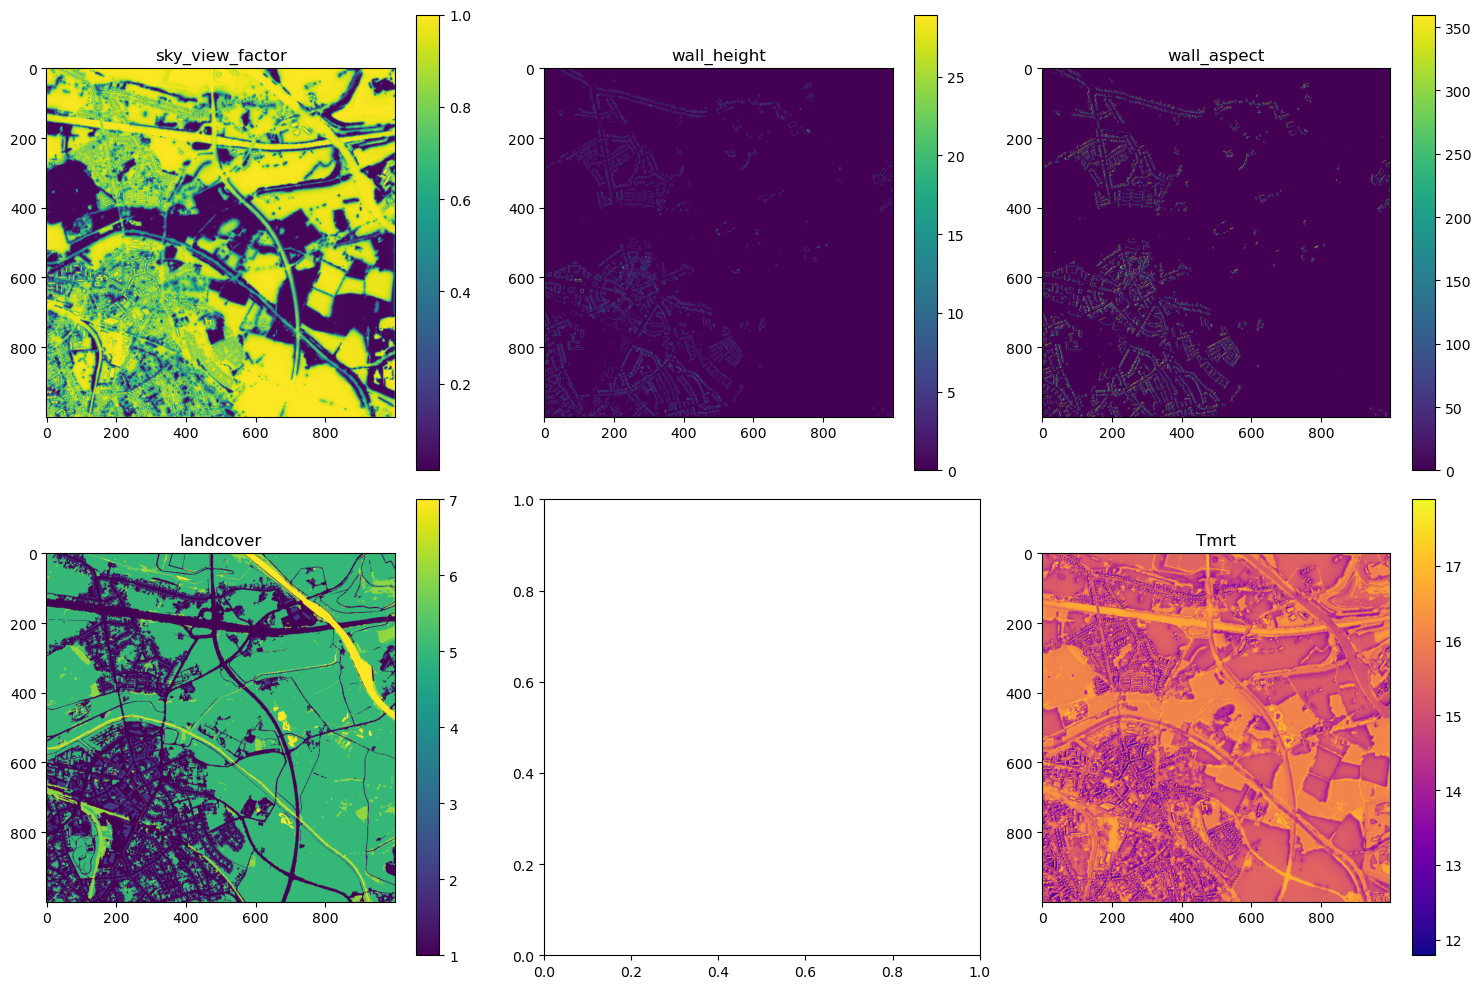

Dataset shapes:
Original data shape: (1000, 1000, 4)
Reshaped training data: (800000, 4)
Reshaped validation data: (200000, 4)
Number of valid data points: 1000000
Feature statistics:
  sky_view_factor: min=0.01, max=1.00, mean=0.65, std=0.36
  wall_height: min=0.00, max=28.94, mean=0.30, std=1.55
  wall_aspect: min=0.00, max=359.99, mean=7.48, std=41.01
  landcover: min=1.00, max=7.00, mean=3.79, std=1.91


In [55]:
# Load raster data
tilenr = "02_04"
data_dir = Path("data") / "static" / tilenr
x_train_locations = [
    {"data": data_dir / f"SkyViewFactor_{tilenr}.tif", "name": "sky_view_factor", "NaN": -9999},
    {"data": data_dir / f"wall_height_{tilenr}.tif", "name": "wall_height", "NaN": -9999},
    {"data": data_dir / f"wall_aspect_{tilenr}.tif", "name": "wall_aspect", "NaN": -9999},
    {"data": data_dir / f"DO_landcover_3m_reclassified_final_{tilenr}.tif", "name": "landcover", "NaN": -9999},
]
y_train_location = {"data": data_dir / f"{tilenr}_Tmrt_3m_v0.6.0_2024_093_1000D.tif", "name": "Tmrt", "NaN": -9999}

# Load X_train rasters
X_train_data = {}
metadata = {}
for data_location in x_train_locations:
    with rasterio.open(data_location["data"]) as src:
        data = src.read(1).astype(np.float32)
        # Store original data statistics for denormalization later
        mask = data != data_location["NaN"]
        metadata[data_location["name"]] = {
            "min": np.nanmin(data[mask]),
            "max": np.nanmax(data[mask]),
            "mean": np.nanmean(data[mask]),
            "std": np.nanstd(data[mask])
        }
        # Handle NaN values
        data[data == data_location["NaN"]] = np.nan
        # Store the data in dictionary
        X_train_data[data_location["name"]] = data

# Load y_train raster
with rasterio.open(y_train_location["data"]) as src:
    y_data = src.read(1).astype(np.float32)
    # Store target metadata
    mask = y_data != y_train_location["NaN"]
    metadata[y_train_location["name"]] = {
        "min": np.nanmin(y_data[mask]),
        "max": np.nanmax(y_data[mask]),
        "mean": np.nanmean(y_data[mask]),
        "std": np.nanstd(y_data[mask]),
        "transform": src.transform,
        "crs": src.crs,
        "shape": src.shape
    }
    # Handle NaN values
    y_data[y_data == y_train_location["NaN"]] = np.nan

# Create valid data mask (where all inputs and target are valid)
valid_mask = np.ones_like(y_data, dtype=bool)
for data in X_train_data.values():
    valid_mask = valid_mask & ~np.isnan(data)
valid_mask = valid_mask & ~np.isnan(y_data)

# Apply normalization and NaN handling to features
X_train_normalized = []
for name, data in X_train_data.items():
    # Z-score normalization for continuous variables
    if name != "landcover":
        data_norm = (data - metadata[name]["mean"]) / metadata[name]["std"]
    else:
        # One-hot encoding would be better for categorical data like landcover
        # For simplicity, just use min-max scaling here
        data_norm = data / metadata[name]["max"]
    
    # Replace NaN with 0 after normalization
    data_norm = np.nan_to_num(data_norm, nan=0.0)
    X_train_normalized.append(data_norm)

# Stack features to create input tensor
X_train = np.stack(X_train_normalized, axis=-1)  # Shape: (height, width, num_channels)

# Normalize target variable
y_train = (y_data - metadata[y_train_location["name"]]["mean"]) / metadata[y_train_location["name"]]["std"]
y_train = np.nan_to_num(y_train, nan=0.0)
y_train = y_train[..., np.newaxis]  # Add channel dimension

# Apply valid mask if needed
# X_train = X_train[valid_mask]
# y_train = y_train[valid_mask]

# Reshape for deep learning models
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])  # Flatten spatial dimensions
y_train_reshaped = y_train.reshape(-1, 1)

# Filter out invalid data points
valid_indices = ~np.isnan(y_train_reshaped).any(axis=1)
X_train_reshaped = X_train_reshaped[valid_indices]
y_train_reshaped = y_train_reshaped[valid_indices]

# Train-test split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_reshaped, y_train_reshaped, test_size=0.2, random_state=42
)

# For CNN models, reshape back to spatial dimensions
# height, width = metadata[y_train_location["name"]]["shape"]
# X_train_cnn = X_train.reshape(1, height, width, X_train.shape[-1])  # Add batch dimension
# y_train_cnn = y_train.reshape(1, height, width, 1)

# Plot data for visualization
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Plot features
for i, (name, data) in enumerate(X_train_data.items()):
    if i < len(axs) - 1:
        im = axs[i].imshow(data, cmap="viridis")
        axs[i].set_title(name)
        plt.colorbar(im, ax=axs[i])

# Plot target
im = axs[-1].imshow(y_data, cmap="plasma")
axs[-1].set_title(y_train_location["name"])
plt.colorbar(im, ax=axs[-1])

plt.tight_layout()
plt.show()

# Print dataset information
print(f"Dataset shapes:")
print(f"Original data shape: {X_train.shape}")
print(f"Reshaped training data: {X_train_split.shape}")
print(f"Reshaped validation data: {X_val_split.shape}")
print(f"Number of valid data points: {valid_indices.sum()}")
print(f"Feature statistics:")
for name, stats in metadata.items():
    if name != y_train_location["name"]:
        print(f"  {name}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, std={stats['std']:.2f}")

In [56]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models

# Keep the same model architecture
def create_unet_model(input_shape, num_features):
    """
    Create a U-Net model for raster data processing.
    
    Args:
        input_shape: Tuple of (height, width, num_features)
        num_features: Number of input features/bands
    
    Returns:
        Compiled Keras model
    """
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Encoder path
    # Level 1
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Level 2
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Level 3 (Bridge)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    
    # Decoder path
    # Level 2
    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat2 = layers.Concatenate()([up2, conv2])
    conv2_up = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv2_up = layers.BatchNormalization()(conv2_up)
    conv2_up = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2_up)
    conv2_up = layers.BatchNormalization()(conv2_up)
    
    # Level 1
    up1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_up)
    concat1 = layers.Concatenate()([up1, conv1])
    conv1_up = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv1_up = layers.BatchNormalization()(conv1_up)
    conv1_up = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1_up)
    conv1_up = layers.BatchNormalization()(conv1_up)
    
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='linear')(conv1_up)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae', 'mse']
    )
    
    return model

# Modified training function for single sample data
def train_unet_model_patch_based(X_train, y_train, patch_size=64, batch_size=8, epochs=50):
    """
    Train the U-Net model using a patch-based approach, which is suitable when
    you have a single large raster but want to create multiple training samples.
    
    Args:
        X_train: Input features array with shape (height, width, num_features)
        y_train: Target array with shape (height, width, 1)
        patch_size: Size of the patches to extract (patch_size x patch_size)
        batch_size: Batch size for training
        epochs: Number of training epochs
    
    Returns:
        Trained model and training history
    """
    # Check if we have a single sample with batch dimension
    if len(X_train.shape) == 4 and X_train.shape[0] == 1:
        X_train = X_train[0]  # Remove batch dimension
    
    if len(y_train.shape) == 4 and y_train.shape[0] == 1:
        y_train = y_train[0]  # Remove batch dimension
    
    # Extract patches from the large raster
    print(f"Original data shape: X={X_train.shape}, y={y_train.shape}")
    
    # Generate patch indices
    height, width = X_train.shape[0], X_train.shape[1]
    num_features = X_train.shape[2]
    
    patches_X = []
    patches_y = []
    
    # Use a stride to create overlapping patches
    stride = patch_size // 2
    
    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            # Extract patch
            patch_X = X_train[i:i+patch_size, j:j+patch_size, :]
            patch_y = y_train[i:i+patch_size, j:j+patch_size, :]
            
            # Check if patch contains valid data (not all zeros or NaNs)
            if np.sum(np.isnan(patch_X)) == 0 and np.sum(np.isnan(patch_y)) == 0:
                if np.sum(patch_y) > 0:  # Ensure patch contains meaningful target data
                    patches_X.append(patch_X)
                    patches_y.append(patch_y)
    
    # Convert to numpy arrays
    X_patches = np.array(patches_X)
    y_patches = np.array(patches_y)
    
    print(f"Created {len(patches_X)} patches of size {patch_size}x{patch_size}")
    print(f"Patches shape: X={X_patches.shape}, y={y_patches.shape}")
    
    # Check if we have enough patches
    if len(patches_X) < 10:
        print("Warning: Very few patches created. Consider decreasing patch_size or stride.")
        if len(patches_X) == 0:
            raise ValueError("No valid patches could be created from the data.")
    
    # Create model with patch size
    model = create_unet_model((patch_size, patch_size, num_features), num_features)
    
    # Print model summary
    model.summary()
    
    # Add callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='loss', 
            patience=10, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_unet_model.h5',
            monitor='loss',
            save_best_only=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Train model with patches
    history = model.fit(
        X_patches, 
        y_patches,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        shuffle=True
    )
    
    return model, history, (X_patches, y_patches)

# Function to predict on the full raster using a patch-based approach
def predict_full_raster(model, X_data, patch_size=64, overlap=32):
    """
    Make predictions on a full raster by using a patch-based approach
    and stitching the results back together.
    
    Args:
        model: Trained U-Net model
        X_data: Input data (height, width, num_features)
        patch_size: Size of patches used for prediction
        overlap: Overlap between patches
        
    Returns:
        Full prediction raster
    """
    # Ensure X_data doesn't have batch dimension
    if len(X_data.shape) == 4 and X_data.shape[0] == 1:
        X_data = X_data[0]
    
    height, width, num_features = X_data.shape
    stride = patch_size - overlap
    
    # Create an empty output raster
    prediction = np.zeros((height, width, 1))
    weight_map = np.zeros((height, width, 1))
    
    # Create a weight matrix that gives higher weight to the center of patches
    weight_matrix = np.ones((patch_size, patch_size, 1))
    for i in range(patch_size):
        for j in range(patch_size):
            # Distance from center (0 to 1)
            di = abs(i - patch_size/2) / (patch_size/2)
            dj = abs(j - patch_size/2) / (patch_size/2)
            # Weight decreases from center to edge
            weight_matrix[i, j, 0] = (1 - di**2) * (1 - dj**2)
    
    # Make predictions on overlapping patches
    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            # Extract patch
            patch = X_data[i:i+patch_size, j:j+patch_size, :]
            
            # Add batch dimension
            patch = np.expand_dims(patch, axis=0)
            
            # Make prediction
            pred_patch = model.predict(patch)
            
            # Remove batch dimension
            pred_patch = pred_patch[0]
            
            # Add weighted prediction to output
            prediction[i:i+patch_size, j:j+patch_size, :] += pred_patch * weight_matrix
            weight_map[i:i+patch_size, j:j+patch_size, :] += weight_matrix
    
    # Normalize by weights
    mask = weight_map > 0
    prediction[mask] = prediction[mask] / weight_map[mask]
    
    return prediction

# Example of how to use these functions:

# After preparing your data
# X_train shape: (height, width, num_features)
# y_train shape: (height, width, 1)

# Train model with patch-based approach
model, history, (X_patches, y_patches) = train_unet_model_patch_based(
    X_train, 
    y_train, 
    patch_size=64, 
    batch_size=8, 
    epochs=50
)

# Visualize training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

# Visualize a few patches
plt.figure(figsize=(12, 6))
for i in range(min(4, len(X_patches))):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_patches[i, :, :, 0], cmap='viridis')
    plt.title(f'Input Patch {i}')
    
    plt.subplot(2, 4, i+5)
    plt.imshow(y_patches[i, :, :, 0], cmap='plasma')
    plt.title(f'Target Patch {i}')
plt.tight_layout()
plt.show()

# Make prediction on the full raster
prediction = predict_full_raster(model, X_train, patch_size=64, overlap=32)

# Visualize result
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_train[:, :, 0], cmap='viridis')
plt.title('Input Feature (first channel)')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(y_train[:, :, 0], cmap='plasma')
plt.title('True Target')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(prediction[:, :, 0], cmap='plasma')
plt.title('Predicted Target')
plt.colorbar()
plt.tight_layout()
plt.show()

# If you need to denormalize the prediction
# Use the metadata from your data preparation step
denormalized_prediction = prediction * metadata['Tmrt']['std'] + metadata['Tmrt']['mean']


Original data shape: X=(1000, 1000, 4), y=(1000, 1000, 1)
Created 454 patches of size 64x64
Patches shape: X=(454, 64, 64, 4), y=(454, 64, 64, 1)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: CUDA error: Error recording CUDA event: CUDA_ERROR_UNKNOWN: unknown error [Op:Cast] name: 